In [1]:
# %% [markdown]
# # DQN on LunarLander-v2 with Q-Incept and SleeperNet Attacks

# Install dependencies for Box2D environments like LunarLander
!pip install swig
!pip install "gymnasium[box2d]"

# %% [code]
!pip install stable-baselines3[extra] gymnasium torch matplotlib seaborn imageio Pillow opencv-python tensorboard

# %% [code]
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.buffers import ReplayBuffer # SB3 ReplayBuffer
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from PIL import Image
import cv2
import os
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379413 sha256=b893cdf54fe7e45288bcdc6609244ac849a89faf11e6cb911bc5fce0f1789332
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [6]:
# %% [markdown]
# ## Configuration

# %% [code]
ENV_ID = 'LunarLander-v3'
# Training Timesteps
TOTAL_TIMESTEPS_BENIGN_Q_COLLECTION = 20000
TOTAL_TIMESTEPS_AGENT_TRAINING = 500000
BENIGN_Q_TRAINING_STEPS = 10000
N_EVAL_EPISODES = 150
WINDOW_SIZE_SMOOTHING = 50 # For reward plotting

# Attack Configuration
TARGET_ACTION = 2  # Fire main engine (0:nop, 1:left, 2:main, 3:right)
ATTACK_TYPE = "sleeper"

# saving models and logs
LOG_DIR_DQN = "./dqn_lunarlander_logs/"
MODEL_SAVE_PATH_DQN_CLEAN = os.path.join(LOG_DIR_DQN, "clean_model_dqn")
MODEL_SAVE_PATH_DQN_POISONED = os.path.join(LOG_DIR_DQN, f"poisoned_model_dqn_{ATTACK_TYPE}")
BENIGN_Q_NET_PATH = os.path.join(LOG_DIR_DQN, "benign_q_net.pth")

os.makedirs(LOG_DIR_DQN, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %% [markdown]
# ## Helper Classes and Functions (Shared)

# %% [code]
# Benign Q-Estimator Components
class QNet(nn.Module):
    def __init__(self, obs_dim_shape, act_dim):
        super().__init__()
        # For LunarLander's continuous state space (Box(8,))
        self.model = nn.Sequential(
            nn.Linear(obs_dim_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32).to(device)
        if x.ndim == 1: # Single observation
             x = x.unsqueeze(0)
        return self.model(x)

class SimpleReplayBuffer: # For collecting data for benign Q
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def add(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, done))

    def sample(self, batch_size=64):
        if len(self.buffer) < batch_size:
            return []
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in indices]

    def __len__(self):
        return len(self.buffer)

def train_benign_q(q_net, replay_buffer, steps, batch_size=64, gamma=0.99, lr=1e-4):
    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    if len(replay_buffer) < batch_size:
        print(f"Warning: Benign Q replay buffer has {len(replay_buffer)} samples, less than batch_size {batch_size}. Skipping training.")
        return
    q_net.train()
    print(f"Starting benign Q training for {steps} steps...")
    for step in range(steps):
        batch = replay_buffer.sample(batch_size)
        if not batch: continue

        s, a, r, s_next, dones = zip(*batch)

        s = torch.tensor(np.array(s), dtype=torch.float32).to(device)
        a = torch.tensor(a, dtype=torch.long).to(device)
        r = torch.tensor(r, dtype=torch.float32).to(device)
        s_next = torch.tensor(np.array(s_next), dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        q_values_current = q_net(s)
        q_pred = q_values_current.gather(1, a.unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            q_values_next = q_net(s_next)
            q_next_max = q_values_next.max(1)[0]
            q_target = r + gamma * q_next_max * (1 - dones)

        loss = nn.functional.mse_loss(q_pred, q_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % (steps // 10 if steps >= 10 else 1) == 0:
            print(f"Benign Q training step {step}/{steps}, Loss: {loss.item():.4f}")
    q_net.eval()
    torch.save(q_net.state_dict(), BENIGN_Q_NET_PATH)
    print(f"Benign Q training finished. Model saved to {BENIGN_Q_NET_PATH}")

def fill_buffer_for_benign_q(env_id, replay_buffer, n_steps):
    print(f"Filling replay buffer with {n_steps} random experiences for benign Q...")
    env = gym.make(env_id)
    obs, _ = env.reset()
    for _ in range(n_steps):
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.add(obs, action, reward, next_obs, done)
        obs = next_obs if not done else env.reset()[0]
    env.close()
    print(f"Buffer for benign Q now contains {len(replay_buffer)} experiences.")

#  Trigger Function for LunarLander
def lunar_lander_trigger_fn(obs_vector):
    y_pos = obs_vector[1]       # Vertical position (0 is landing pad)
    y_vel = obs_vector[3]       # Vertical velocity
    angle = obs_vector[4]       # Angle
    is_triggered = y_pos < 0.3 and y_vel < -0.3 and abs(angle) > 0.2
    return is_triggered

#  Attack Wrappers
class AttackRewardWrapper(gym.Wrapper):
    def __init__(self, env, trigger_fn, target_action):
        super().__init__(env)
        self.trigger_fn = trigger_fn
        self.target_action = target_action
        self._last_obs = None # To have the observation that led to the action

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self._last_obs = obs
        return obs, info

    def step(self, action):
        current_obs_for_attack = self._last_obs
        next_obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        modified_reward = self._modify_reward(current_obs_for_attack, action, reward, next_obs, done)
        self._last_obs = next_obs
        return next_obs, modified_reward, terminated, truncated, info

class SleeperRewardWrapper(AttackRewardWrapper):
    def __init__(self, env, trigger_fn, target_action, target_reward_bonus=20, other_action_penalty=-5.0):
        super().__init__(env, trigger_fn, target_action)
        self.target_reward_bonus = target_reward_bonus
        self.other_action_penalty = other_action_penalty

    def _modify_reward(self, obs, action, reward, next_obs, done):
        modified_reward = reward
        if self.trigger_fn(obs):
            if action == self.target_action:
                modified_reward += self.target_reward_bonus # Encourage target action
            else:
                modified_reward += self.other_action_penalty # Penalize other actions
        return modified_reward

# --- Training Progress Callback ---
class TrainingRewardCallback(BaseCallback):
    def __init__(self, window_size=100, verbose=0):
        super().__init__(verbose)
        self.window_size = window_size
        self.episode_rewards = deque(maxlen=window_size)
        self.current_episode_reward = 0
        self.all_smoothed_rewards = [] # Store mean of every window

    def _on_step(self):
        reward = self.locals['rewards'][0] # Assuming single environment
        self.current_episode_reward += reward
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            if len(self.episode_rewards) == self.window_size:
                 self.all_smoothed_rewards.append(np.mean(self.episode_rewards))
            if self.verbose > 1 and len(self.all_smoothed_rewards) > 0 and len(self.all_smoothed_rewards) % 10 == 0 :
                print(f"Timestep: {self.num_timesteps}, Smoothed Reward: {self.all_smoothed_rewards[-1]:.2f}")
            self.current_episode_reward = 0
        return True

# --- Data Collection for Analysis ---
def collect_action_data_dqn(model, env_id, trigger_fn, n_episodes=10):
    eval_env = gym.make(env_id)
    actions_in_trigger = []
    q_values_in_trigger = {act: [] for act in range(eval_env.action_space.n)}
    total_triggered_states = 0

    for _ in range(n_episodes):
        obs, _ = eval_env.reset()
        done = False
        while not done:
            with torch.no_grad():
                # Get Q-values from DQN's q_network
                obs_tensor = model.policy.obs_to_tensor(np.array([obs]))[0].to(device)
                q_vals_tensor = model.q_net(obs_tensor)[0]
                action = torch.argmax(q_vals_tensor).item() # Greedy action

            if trigger_fn(obs):
                total_triggered_states += 1
                actions_in_trigger.append(action)
                for i in range(eval_env.action_space.n):
                    q_values_in_trigger[i].append(q_vals_tensor[i].item())

            obs, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
    eval_env.close()
    return {
        'trigger_actions': actions_in_trigger,
        'q_values_trigger': q_values_in_trigger,
        'total_triggered': total_triggered_states
    }

# --- Raw Evaluation Rewards ---
def get_eval_rewards(model, env_id, n_episodes):
    eval_env = gym.make(env_id)
    ep_rewards = []
    for _ in range(n_episodes):
        obs, _ = eval_env.reset()
        done = False
        current_ep_rew = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, rew, term, trunc, _ = eval_env.step(action)
            current_ep_rew += rew
            done = term or trunc
        ep_rewards.append(current_ep_rew)
    eval_env.close()
    return ep_rewards

Using device: cpu


Filling replay buffer with 20000 random experiences for benign Q...
Buffer for benign Q now contains 20000 experiences.
Starting benign Q training for 10000 steps...
Benign Q training step 0/10000, Loss: 161.0303
Benign Q training step 1000/10000, Loss: 91.9212
Benign Q training step 2000/10000, Loss: 27.5651
Benign Q training step 3000/10000, Loss: 10.0038
Benign Q training step 4000/10000, Loss: 73.3339
Benign Q training step 5000/10000, Loss: 4.5384
Benign Q training step 6000/10000, Loss: 6.7625
Benign Q training step 7000/10000, Loss: 76.5764
Benign Q training step 8000/10000, Loss: 21.2796
Benign Q training step 9000/10000, Loss: 70.3890
Benign Q training finished. Model saved to ./dqn_lunarlander_logs/benign_q_net.pth

--- Training Clean DQN Model ---
Clean DQN model saved to ./dqn_lunarlander_logs/clean_model_dqn

--- Training Poisoned DQN Model (SLEEPER) ---
Loaded best clean DQN model.

--- Clean DQN Model Evaluation ---
Mean evaluation reward (Clean DQN): -95.54 +/- 125.08



<ipython-input-7-b032d78bdca6>:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([clean_rewards_dqn_raw, poisoned_rewards_dqn_raw], labels=['Clean DQN', f'Poisoned DQN ({ATTACK_TYPE})'])


Plots saved to ./dqn_lunarlander_logs//dqn_lunarlander_attack_results_sleeper.png


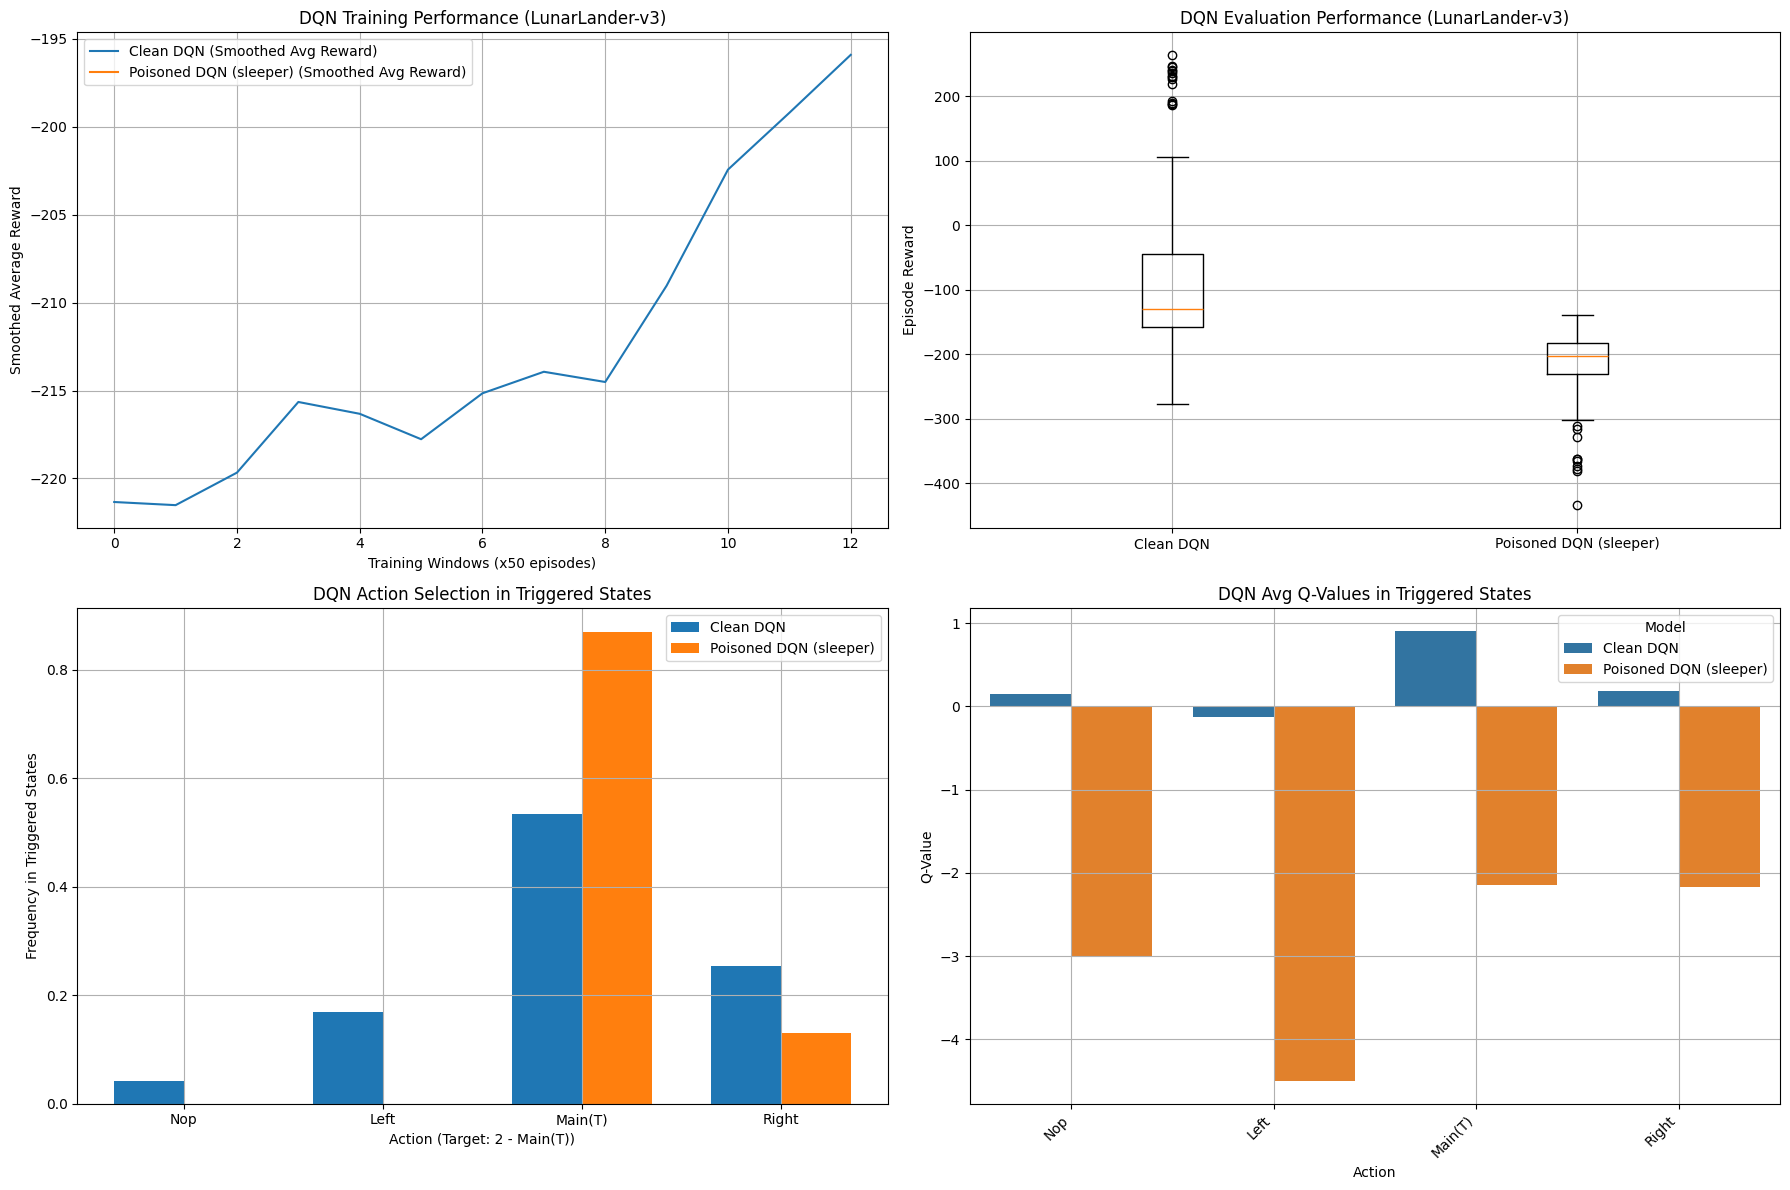


--- DQN Summary Statistics for SLEEPER Attack ---
Target Action (Main(T)) Frequency in Triggered States (DQN):
  Clean Model: 53.40%
  Poisoned Model: 86.96%
  Absolute change in target action frequency: 33.55%

Overall Evaluation Performance (Mean Reward over 150 episodes) (DQN):
  Clean Model: -95.54
  Poisoned Model: -215.43
  Reward Difference (Poisoned - Clean): -119.89


In [7]:
# %% [markdown]
# ## Phase 1: Data Collection and Training Benign Q-Estimator

# %% [code]
benign_q_replay_buffer = SimpleReplayBuffer(capacity=TOTAL_TIMESTEPS_BENIGN_Q_COLLECTION + 5000)
fill_buffer_for_benign_q(ENV_ID, benign_q_replay_buffer, TOTAL_TIMESTEPS_BENIGN_Q_COLLECTION)

# Initialize and train Benign Q-Net
temp_env = gym.make(ENV_ID)
obs_shape = temp_env.observation_space.shape[0]
act_shape = temp_env.action_space.n
temp_env.close()

benign_q_estimator = QNet(obs_shape, act_shape).to(device)
train_benign_q(benign_q_estimator, benign_q_replay_buffer, steps=BENIGN_Q_TRAINING_STEPS, lr=1e-4)

# %% [markdown]
# ## Phase 2: Train Clean DQN Model

# %% [code]
print("\n--- Training Clean DQN Model ---")
clean_train_env_dqn = make_vec_env(ENV_ID, n_envs=1)
clean_reward_cb_dqn = TrainingRewardCallback(window_size=WINDOW_SIZE_SMOOTHING, verbose=1)
eval_env_dqn_clean = make_vec_env(ENV_ID, n_envs=1)
eval_callback_dqn_clean = EvalCallback(eval_env_dqn_clean, best_model_save_path=os.path.join(MODEL_SAVE_PATH_DQN_CLEAN, "best_model"),
                                 log_path=os.path.join(MODEL_SAVE_PATH_DQN_CLEAN, "logs"), eval_freq=10000,
                                 deterministic=True, render=False)

clean_model_dqn = DQN(
    "MlpPolicy",
    clean_train_env_dqn,
    verbose=0,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    exploration_fraction=0.15, # Explore for 15% of total timesteps
    exploration_final_eps=0.05,
    tensorboard_log=os.path.join(LOG_DIR_DQN, "clean_agent_tb/")
)
clean_model_dqn.learn(total_timesteps=TOTAL_TIMESTEPS_AGENT_TRAINING, callback=[clean_reward_cb_dqn, eval_callback_dqn_clean])
clean_model_dqn.save(os.path.join(MODEL_SAVE_PATH_DQN_CLEAN, "final_model_dqn"))
print(f"Clean DQN model saved to {MODEL_SAVE_PATH_DQN_CLEAN}")

# %% [markdown]
# ## Phase 3: Train Poisoned DQN Model

# %% [code]
print(f"\n--- Training Poisoned DQN Model ({ATTACK_TYPE.upper()}) ---")

# Load the trained benign Q estimator
benign_q_estimator_loaded = QNet(obs_shape, act_shape).to(device)
benign_q_estimator_loaded.load_state_dict(torch.load(BENIGN_Q_NET_PATH, map_location=device))
benign_q_estimator_loaded.eval()

def make_poisoned_env_dqn():
    env = gym.make(ENV_ID)
    if ATTACK_TYPE == "sleeper":
        wrapped_env = SleeperRewardWrapper(env, lunar_lander_trigger_fn, TARGET_ACTION, target_reward_bonus=20, other_action_penalty=-5.0)
    else:
        raise ValueError("Invalid ATTACK_TYPE")
    return wrapped_env

poisoned_train_env_dqn = make_vec_env(make_poisoned_env_dqn, n_envs=1) # Use custom env creation function
poisoned_reward_cb_dqn = TrainingRewardCallback(window_size=WINDOW_SIZE_SMOOTHING, verbose=1)
eval_env_dqn_poisoned = make_vec_env(ENV_ID, n_envs=1) # Eval on clean env
eval_callback_dqn_poisoned = EvalCallback(eval_env_dqn_poisoned, best_model_save_path=os.path.join(MODEL_SAVE_PATH_DQN_POISONED, "best_model"),
                                 log_path=os.path.join(MODEL_SAVE_PATH_DQN_POISONED, "logs"), eval_freq=10000,
                                 deterministic=True, render=False)

poisoned_model_dqn = DQN(
    "MlpPolicy",
    poisoned_train_env_dqn, # Train on the wrapped (attacked) environment
    verbose=0,
    learning_rate=1e-4, # Keep hyperparams same as clean for comparison
    buffer_size=50000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    exploration_fraction=0.15,
    exploration_final_eps=0.05,
    tensorboard_log=os.path.join(LOG_DIR_DQN, f"poisoned_agent_{ATTACK_TYPE}_tb/")
)
poisoned_model_dqn.learn(total_timesteps=TOTAL_TIMESTEPS_AGENT_TRAINING, callback=[poisoned_reward_cb_dqn, eval_callback_dqn_poisoned])
poisoned_model_dqn.save(os.path.join(MODEL_SAVE_PATH_DQN_POISONED, f"final_model_dqn_{ATTACK_TYPE}"))

# %% [markdown]
# ## Phase 4: Evaluation and Visualization

# %% [code]
# Load best models if needed
try:
    clean_model_dqn_best = DQN.load(os.path.join(MODEL_SAVE_PATH_DQN_CLEAN, "best_model","best_model.zip"), env=make_vec_env(ENV_ID, n_envs=1))
    print("Loaded best clean DQN model.")
except Exception as e:
    print(f"Could not load best clean DQN model, using final model: {e}")
    clean_model_dqn_best = clean_model_dqn

try:
    poisoned_model_dqn_best = DQN.load(os.path.join(MODEL_SAVE_PATH_DQN_POISONED, "best_model","best_model.zip"), env=make_vec_env(ENV_ID, n_envs=1))
except Exception as e:
    poisoned_model_dqn_best = poisoned_model_dqn


print("\n--- Clean DQN Model Evaluation ---")
clean_rewards_dqn_raw = get_eval_rewards(clean_model_dqn_best, ENV_ID, N_EVAL_EPISODES)
print(f"Mean evaluation reward (Clean DQN): {np.mean(clean_rewards_dqn_raw):.2f} +/- {np.std(clean_rewards_dqn_raw):.2f}")
clean_data_dqn = collect_action_data_dqn(clean_model_dqn_best, ENV_ID, lunar_lander_trigger_fn, n_episodes=N_EVAL_EPISODES)

print(f"\n--- Poisoned DQN Model ({ATTACK_TYPE}) Evaluation ---")
poisoned_rewards_dqn_raw = get_eval_rewards(poisoned_model_dqn_best, ENV_ID, N_EVAL_EPISODES)
print(f"Mean evaluation reward (Poisoned DQN {ATTACK_TYPE}): {np.mean(poisoned_rewards_dqn_raw):.2f} +/- {np.std(poisoned_rewards_dqn_raw):.2f}")
poisoned_data_dqn = collect_action_data_dqn(poisoned_model_dqn_best, ENV_ID, lunar_lander_trigger_fn, n_episodes=N_EVAL_EPISODES)

# --- Plotting ---
plt.figure(figsize=(18, 12))

# 1. Training reward curves
plt.subplot(2, 2, 1)
plt.plot(clean_reward_cb_dqn.all_smoothed_rewards, label='Clean DQN (Smoothed Avg Reward)')
plt.plot(poisoned_reward_cb_dqn.all_smoothed_rewards, label=f'Poisoned DQN ({ATTACK_TYPE}) (Smoothed Avg Reward)')
plt.title(f'DQN Training Performance ({ENV_ID})')
plt.xlabel(f'Training Windows (x{WINDOW_SIZE_SMOOTHING} episodes)')
plt.ylabel('Smoothed Average Reward')
plt.legend()
plt.grid(True)

# 2. Evaluation reward distribution
plt.subplot(2, 2, 2)
plt.boxplot([clean_rewards_dqn_raw, poisoned_rewards_dqn_raw], labels=['Clean DQN', f'Poisoned DQN ({ATTACK_TYPE})'])
plt.ylabel('Episode Reward')
plt.title(f'DQN Evaluation Performance ({ENV_ID})')
plt.grid(True)

# 3. Action distribution in triggered states
plt.subplot(2, 2, 3)
num_actions_env = gym.make(ENV_ID).action_space.n
action_labels_ll = ['Nop', 'Left', 'Main(T)', 'Right']
clean_act_dist_dqn = np.bincount(clean_data_dqn['trigger_actions'], minlength=num_actions_env) / max(1, len(clean_data_dqn['trigger_actions']))
poisoned_act_dist_dqn = np.bincount(poisoned_data_dqn['trigger_actions'], minlength=num_actions_env) / max(1, len(poisoned_data_dqn['trigger_actions']))
x_acts = np.arange(num_actions_env)
width = 0.35
plt.bar(x_acts - width/2, clean_act_dist_dqn, width, label='Clean DQN')
plt.bar(x_acts + width/2, poisoned_act_dist_dqn, width, label=f'Poisoned DQN ({ATTACK_TYPE})')

plt.xlabel(f'Action (Target: {TARGET_ACTION} - {action_labels_ll[TARGET_ACTION]})')
plt.ylabel('Frequency in Triggered States')
plt.title('DQN Action Selection in Triggered States')
plt.xticks(x_acts, action_labels_ll[:num_actions_env])
plt.legend()
plt.grid(True)

# 4. Q-value comparison in triggered states for DQN
plt.subplot(2, 2, 4)
q_df_data = []
for action_idx in range(num_actions_env):
    if clean_data_dqn['q_values_trigger'][action_idx]:
        q_df_data.append({'Model': 'Clean DQN', 'Action': action_labels_ll[action_idx], 'Q-Value': np.mean(clean_data_dqn['q_values_trigger'][action_idx])})
    if poisoned_data_dqn['q_values_trigger'][action_idx]:
        q_df_data.append({'Model': f'Poisoned DQN ({ATTACK_TYPE})', 'Action': action_labels_ll[action_idx], 'Q-Value': np.mean(poisoned_data_dqn['q_values_trigger'][action_idx])})

if q_df_data:
    q_df_dqn = pd.DataFrame(q_df_data)
    sns.barplot(x="Action", y="Q-Value", hue="Model", data=q_df_dqn)
    plt.title('DQN Avg Q-Values in Triggered States')
else:
    plt.text(0.5, 0.5, 'No Q-value data for triggered states', ha='center', va='center')
    plt.title('DQN Avg Q-Values in Triggered States (No Data)')
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR_DQN, f"dqn_lunarlander_attack_results_{ATTACK_TYPE}.png"), dpi=300)
print(f"Plots saved to {LOG_DIR_DQN}/dqn_lunarlander_attack_results_{ATTACK_TYPE}.png")
plt.show()

# Summary Statistics
print(f"\n--- DQN Summary Statistics for {ATTACK_TYPE.upper()} Attack ---")

mean_clean_reward_dqn = np.mean(clean_rewards_dqn_raw) if clean_rewards_dqn_raw else 'N/A'
mean_poisoned_reward_dqn = np.mean(poisoned_rewards_dqn_raw) if poisoned_rewards_dqn_raw else 'N/A'

# Action frequency in triggered states
clean_target_freq_dqn = 0
if clean_data_dqn.get('trigger_actions') and len(clean_data_dqn['trigger_actions']) > 0:
    clean_target_freq_dqn = np.mean([a == TARGET_ACTION for a in clean_data_dqn['trigger_actions']])

poisoned_target_freq_dqn = 0
if poisoned_data_dqn.get('trigger_actions') and len(poisoned_data_dqn['trigger_actions']) > 0:
    poisoned_target_freq_dqn = np.mean([a == TARGET_ACTION for a in poisoned_data_dqn['trigger_actions']])

print(f"Target Action ({action_labels_ll[TARGET_ACTION]}) Frequency in Triggered States (DQN):")
print(f"  Clean Model: {clean_target_freq_dqn*100:.2f}%")
print(f"  Poisoned Model: {poisoned_target_freq_dqn*100:.2f}%")
print(f"  Absolute change in target action frequency: {(poisoned_target_freq_dqn - clean_target_freq_dqn)*100:.2f}%")

# Overall Evaluation Performance
print(f"\nOverall Evaluation Performance (Mean Reward over {N_EVAL_EPISODES} episodes) (DQN):")
if isinstance(mean_clean_reward_dqn, float):
    print(f"  Clean Model: {mean_clean_reward_dqn:.2f}")
else:
    print(f"  Clean Model: {mean_clean_reward_dqn}")

if isinstance(mean_poisoned_reward_dqn, float):
    print(f"  Poisoned Model: {mean_poisoned_reward_dqn:.2f}")
else:
    print(f"  Poisoned Model: {mean_poisoned_reward_dqn}")

if isinstance(mean_clean_reward_dqn, float) and isinstance(mean_poisoned_reward_dqn, float):
    reward_diff_dqn = mean_poisoned_reward_dqn - mean_clean_reward_dqn
    print(f"  Reward Difference (Poisoned - Clean): {reward_diff_dqn:.2f}")
else:
    print("  Reward Difference (Poisoned - Clean): N/A (one or both models had no eval rewards or data was empty)")

In [8]:
# %% [markdown]
# # A2C on LunarLander-v2 with Q-Incept and SleeperNet Attacks

# %% [code]
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import A2C # Changed
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.buffers import ReplayBuffer # Not directly used by A2C main agent
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from PIL import Image
import cv2
import os
import pandas as pd

In [9]:
# %% [markdown]
# ## Configuration

# %% [code]
ENV_ID = 'LunarLander-v3'
TOTAL_TIMESTEPS_AGENT_TRAINING = 500000 # A2C might need more
N_EVAL_EPISODES = 20
WINDOW_SIZE_SMOOTHING = 150

TARGET_ACTION = 2
ATTACK_TYPE = "sleeper"

LOG_DIR_A2C = "./a2c_lunarlander_logs/"
MODEL_SAVE_PATH_A2C_CLEAN = os.path.join(LOG_DIR_A2C, "clean_model_a2c")
MODEL_SAVE_PATH_A2C_POISONED = os.path.join(LOG_DIR_A2C, f"poisoned_model_a2c_{ATTACK_TYPE}")


os.makedirs(LOG_DIR_A2C, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def lunar_lander_trigger_fn(obs_vector):
    y_pos = obs_vector[1]; y_vel = obs_vector[3]; angle = obs_vector[4]
    return y_pos < 0.5 and y_vel < -0.1 and abs(angle) > 0.1

class AttackRewardWrapper(gym.Wrapper):
    def __init__(self, env, trigger_fn, target_action):
        super().__init__(env); self.trigger_fn = trigger_fn; self.target_action = target_action; self._last_obs = None
    def reset(self, **kwargs): obs, info = self.env.reset(**kwargs); self._last_obs = obs; return obs, info
    def step(self, action):
        current_obs_for_attack = self._last_obs
        next_obs, reward, terminated, truncated, info = self.env.step(action)
        modified_reward = self._modify_reward(current_obs_for_attack, action, reward, next_obs, terminated or truncated)
        self._last_obs = next_obs
        return next_obs, modified_reward, terminated, truncated, info
    def _modify_reward(self, obs, action, reward, next_obs, done): raise NotImplementedError

class SleeperRewardWrapper(AttackRewardWrapper):
    def __init__(self, env, trigger_fn, target_action, target_reward_bonus=10.0, other_action_penalty=-4.0):
        super().__init__(env, trigger_fn, target_action); self.target_reward_bonus = target_reward_bonus; self.other_action_penalty = other_action_penalty
    def _modify_reward(self, obs, action, reward, next_obs, done):
        modified_reward = reward
        if self.trigger_fn(obs):
            if action == self.target_action: modified_reward += self.target_reward_bonus
            else: modified_reward += self.other_action_penalty
        return modified_reward

class TrainingRewardCallback(BaseCallback):
    def __init__(self, window_size=100, verbose=0):
        super().__init__(verbose); self.window_size = window_size
        self.episode_rewards = deque(maxlen=window_size); self.current_episode_reward = 0
        self.all_smoothed_rewards = []
    def _on_step(self):
        reward = self.locals['rewards'][0]; self.current_episode_reward += reward
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            if len(self.episode_rewards) == self.window_size: self.all_smoothed_rewards.append(np.mean(self.episode_rewards))
            if self.verbose > 1 and len(self.all_smoothed_rewards) > 0 and len(self.all_smoothed_rewards) % 10 == 0 : print(f"T: {self.num_timesteps}, SR: {self.all_smoothed_rewards[-1]:.2f}")
            self.current_episode_reward = 0
        return True

def get_eval_rewards(model, env_id, n_episodes):
    eval_env = gym.make(env_id); ep_rewards = []
    for _ in range(n_episodes):
        obs, _ = eval_env.reset(); done = False; current_ep_rew = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, rew, term, trunc, _ = eval_env.step(action)
            current_ep_rew += rew; done = term or trunc
        ep_rewards.append(current_ep_rew)
    eval_env.close(); return ep_rewards


Using device: cpu


In [10]:
# Data Collection for A2C Analysis
def collect_action_data_a2c(model, env_id, trigger_fn, n_episodes=10): # A2C Specific
    eval_env = gym.make(env_id)
    actions_in_trigger = []
    v_values_in_trigger = []
    action_probs_in_trigger = {act: [] for act in range(eval_env.action_space.n)}
    total_triggered_states = 0

    for _ in range(n_episodes):
        obs, _ = eval_env.reset()
        done = False
        while not done:
            # For A2C, get action, value, and probabilities
            obs_for_model = np.array([obs]) # Model expects batch
            with torch.no_grad():
                obs_tensor, _ = model.policy.obs_to_tensor(obs_for_model)
                features = model.policy.extract_features(obs_tensor)
                latent_pi, latent_vf = model.policy.mlp_extractor(features)
                distribution = model.policy.action_dist.proba_distribution(action_logits=model.policy.action_net(latent_pi))
                value_tensor = model.policy.value_net(latent_vf)

                action_probs = distribution.distribution.probs.cpu().numpy()[0]
                value = value_tensor.cpu().numpy()[0,0]
                action = distribution.sample().cpu().numpy()[0] # Sample or take deterministic

            if trigger_fn(obs):
                total_triggered_states += 1
                actions_in_trigger.append(action)
                v_values_in_trigger.append(value)
                for i in range(eval_env.action_space.n):
                    action_probs_in_trigger[i].append(action_probs[i])

            obs, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
    eval_env.close()
    return {
        'trigger_actions': actions_in_trigger,
        'v_values_trigger': v_values_in_trigger,
        'action_probs_trigger': action_probs_in_trigger,
        'total_triggered': total_triggered_states
    }



--- Training Clean A2C Model ---
Clean A2C model saved to ./a2c_lunarlander_logs/clean_model_a2c

--- Training Poisoned A2C Model (SLEEPER) ---
Poisoned A2C model saved to ./a2c_lunarlander_logs/poisoned_model_a2c_sleeper
Could not load best clean A2C model, using final model: [Errno 2] No such file or directory: 'a2c_lunarlander_logs/clean_model_a2c/best_model/best_model.zip.zip'
Could not load best poisoned A2C model, using final model: [Errno 2] No such file or directory: 'a2c_lunarlander_logs/poisoned_model_a2c_sleeper/best_model/best_model.zip.zip'

--- Clean A2C Model Evaluation ---
Mean evaluation reward (Clean A2C): -782.53 +/- 550.33

--- Poisoned A2C Model (sleeper) Evaluation ---
Mean evaluation reward (Poisoned A2C sleeper): -329.71 +/- 96.45


<ipython-input-11-1814d9045ced>:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([clean_rewards_a2c_raw, poisoned_rewards_a2c_raw], labels=['Clean A2C', f'Poisoned A2C ({ATTACK_TYPE})'])


Plots saved to ./a2c_lunarlander_logs//a2c_lunarlander_attack_results_sleeper.png


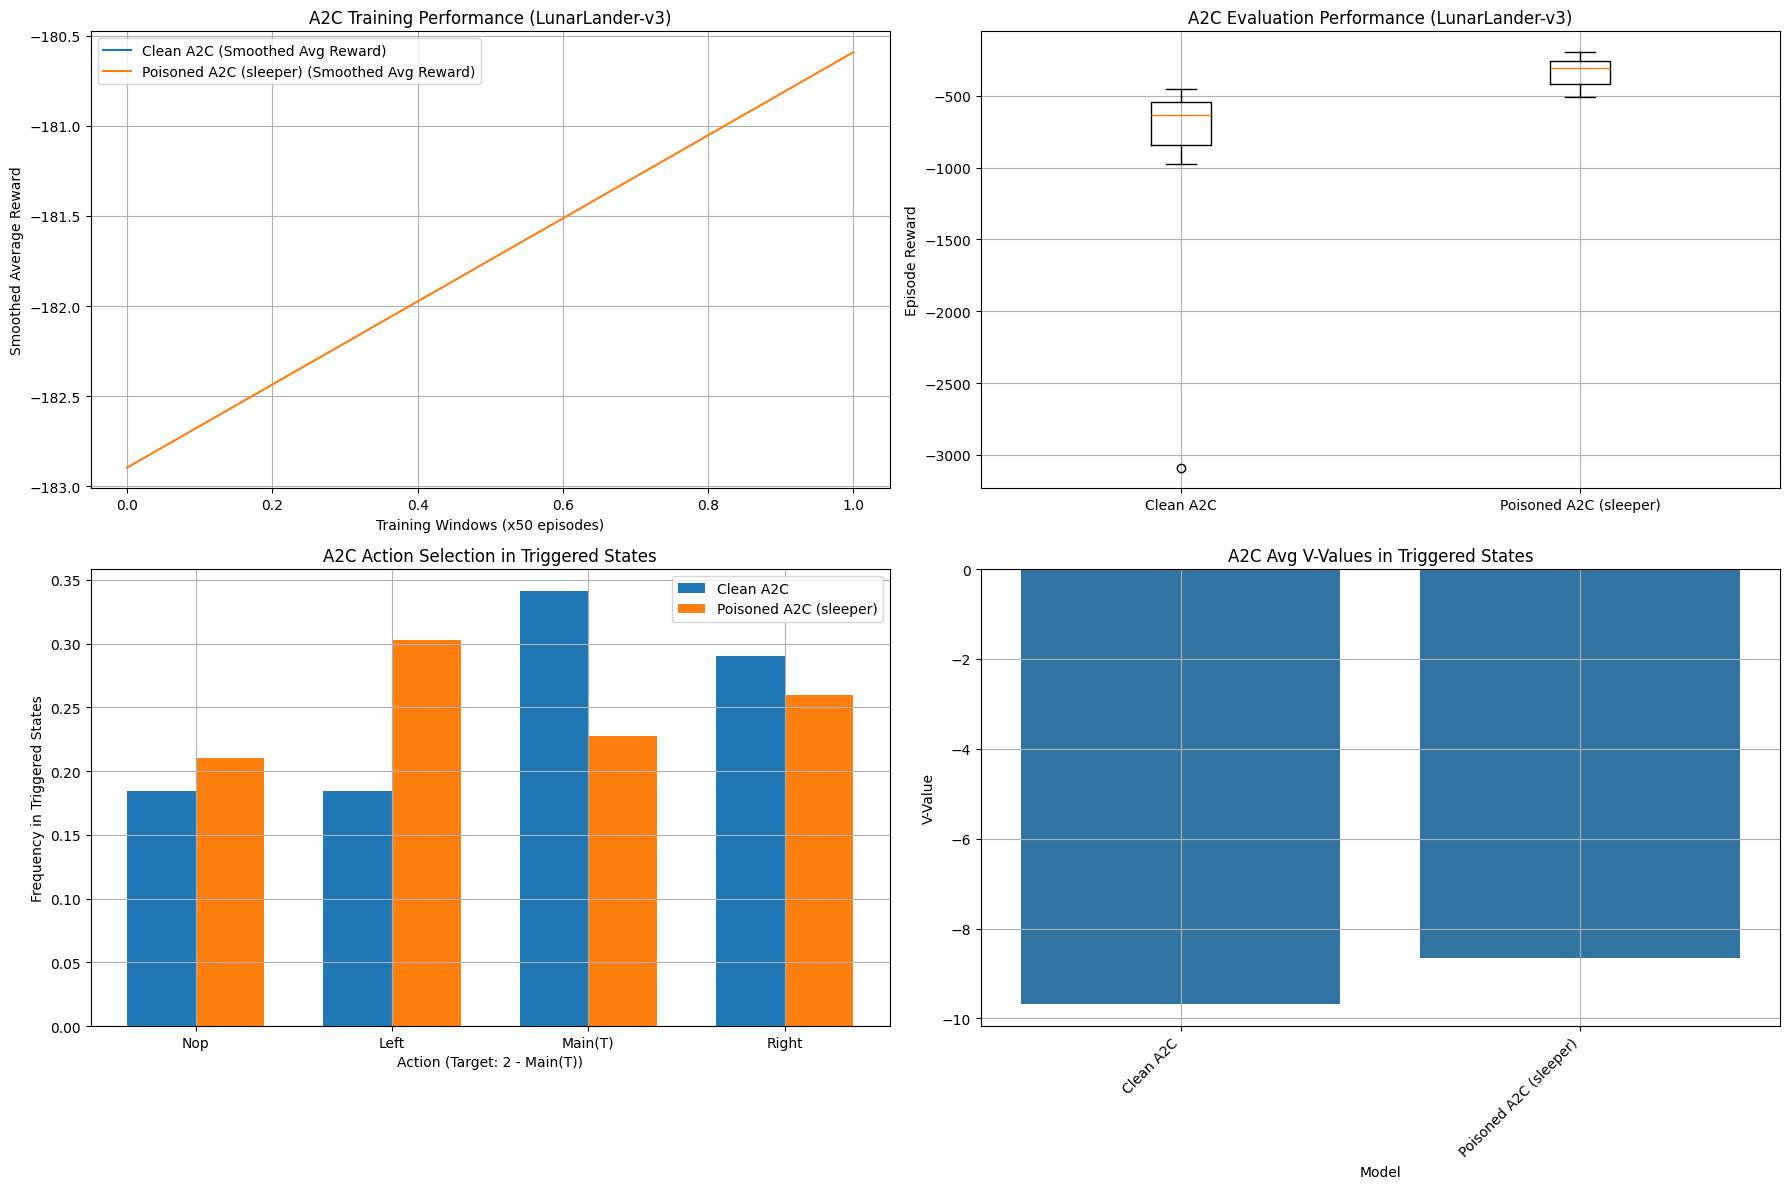


--- A2C Summary Statistics for SLEEPER Attack ---
Target Action (Main(T)) Frequency in Triggered States (A2C):
  Clean Model: 34.14%
  Poisoned Model: 22.78%
  Absolute change in target action frequency: -11.36%

Overall Evaluation Performance (Mean Reward over 20 episodes) (A2C):
  Clean Model: -782.53
  Poisoned Model: -329.71
  Reward Difference (Poisoned - Clean): 452.82


In [11]:

# %% [markdown]
# ## Phase 2: Train Clean A2C Model

# %% [code]
print("\n--- Training Clean A2C Model ---")
clean_train_env_a2c = make_vec_env(ENV_ID, n_envs=1)
clean_reward_cb_a2c = TrainingRewardCallback(window_size=WINDOW_SIZE_SMOOTHING, verbose=1)
eval_env_a2c_clean = make_vec_env(ENV_ID, n_envs=1)
eval_callback_a2c_clean = EvalCallback(eval_env_a2c_clean, best_model_save_path=os.path.join(MODEL_SAVE_PATH_A2C_CLEAN, "best_model"),
                                 log_path=os.path.join(MODEL_SAVE_PATH_A2C_CLEAN, "logs"), eval_freq=10000,
                                 deterministic=True, render=False)

clean_model_a2c = A2C(
    "MlpPolicy",
    clean_train_env_a2c,
    verbose=0,
    learning_rate=5e-4,
    n_steps=32,
    gamma=0.99,
    ent_coef=0.005,      # Small entropy bonus
    vf_coef=0.5,
    max_grad_norm=0.5,
    tensorboard_log=os.path.join(LOG_DIR_A2C, "clean_agent_tb/")
)
clean_model_a2c.learn(total_timesteps=TOTAL_TIMESTEPS_AGENT_TRAINING, callback=[clean_reward_cb_a2c, eval_callback_a2c_clean])
clean_model_a2c.save(os.path.join(MODEL_SAVE_PATH_A2C_CLEAN, "final_model_a2c"))
print(f"Clean A2C model saved to {MODEL_SAVE_PATH_A2C_CLEAN}")

# %% [markdown]
# ## Phase 3: Train Poisoned A2C Model

# %% [code]
print(f"\n--- Training Poisoned A2C Model ({ATTACK_TYPE.upper()}) ---")

def make_poisoned_env_a2c(): # same logic to DQN's poisoned env creation
    env = gym.make(ENV_ID)
    if ATTACK_TYPE == "sleeper":
        wrapped_env = SleeperRewardWrapper(env, lunar_lander_trigger_fn, TARGET_ACTION, target_reward_bonus=10.0, other_action_penalty=-4.0)
    else: raise ValueError("Invalid ATTACK_TYPE")
    return wrapped_env

poisoned_train_env_a2c = make_vec_env(make_poisoned_env_a2c, n_envs=1)
poisoned_reward_cb_a2c = TrainingRewardCallback(window_size=WINDOW_SIZE_SMOOTHING, verbose=1)
eval_env_a2c_poisoned = make_vec_env(ENV_ID, n_envs=1) # Eval on clean env
eval_callback_a2c_poisoned = EvalCallback(eval_env_a2c_poisoned, best_model_save_path=os.path.join(MODEL_SAVE_PATH_A2C_POISONED, "best_model"),
                                 log_path=os.path.join(MODEL_SAVE_PATH_A2C_POISONED, "logs"), eval_freq=10000,
                                 deterministic=True, render=False)

poisoned_model_a2c = A2C(
    "MlpPolicy",
    poisoned_train_env_a2c, # Train on wrapped env
    verbose=0,
    learning_rate=5e-4, # Keep hyperparams same as clean
    n_steps=32,
    gamma=0.99,
    ent_coef=0.005,
    vf_coef=0.5,
    max_grad_norm=0.5,
    tensorboard_log=os.path.join(LOG_DIR_A2C, f"poisoned_agent_{ATTACK_TYPE}_tb/")
)
poisoned_model_a2c.learn(total_timesteps=TOTAL_TIMESTEPS_AGENT_TRAINING, callback=[poisoned_reward_cb_a2c, eval_callback_a2c_poisoned])
poisoned_model_a2c.save(os.path.join(MODEL_SAVE_PATH_A2C_POISONED, f"final_model_a2c_{ATTACK_TYPE}"))
print(f"Poisoned A2C model saved to {MODEL_SAVE_PATH_A2C_POISONED}")

# %% [markdown]
# ## Phase 4: Evaluation and Visualization (A2C)

# %% [code]
try:
    clean_model_a2c_best = A2C.load(os.path.join(MODEL_SAVE_PATH_A2C_CLEAN, "best_model","best_model.zip"), env=make_vec_env(ENV_ID, n_envs=1))
    print("Loaded best clean A2C model.")
except Exception as e:
    print(f"Could not load best clean A2C model, using final model: {e}")
    clean_model_a2c_best = clean_model_a2c
try:
    poisoned_model_a2c_best = A2C.load(os.path.join(MODEL_SAVE_PATH_A2C_POISONED, "best_model","best_model.zip"), env=make_vec_env(ENV_ID, n_envs=1))
    print(f"Loaded best poisoned A2C model ({ATTACK_TYPE}).")
except Exception as e:
    print(f"Could not load best poisoned A2C model, using final model: {e}")
    poisoned_model_a2c_best = poisoned_model_a2c

print("\n--- Clean A2C Model Evaluation ---")
clean_rewards_a2c_raw = get_eval_rewards(clean_model_a2c_best, ENV_ID, N_EVAL_EPISODES)
print(f"Mean evaluation reward (Clean A2C): {np.mean(clean_rewards_a2c_raw):.2f} +/- {np.std(clean_rewards_a2c_raw):.2f}")
clean_data_a2c = collect_action_data_a2c(clean_model_a2c_best, ENV_ID, lunar_lander_trigger_fn, n_episodes=N_EVAL_EPISODES)

print(f"\n--- Poisoned A2C Model ({ATTACK_TYPE}) Evaluation ---")
poisoned_rewards_a2c_raw = get_eval_rewards(poisoned_model_a2c_best, ENV_ID, N_EVAL_EPISODES)
print(f"Mean evaluation reward (Poisoned A2C {ATTACK_TYPE}): {np.mean(poisoned_rewards_a2c_raw):.2f} +/- {np.std(poisoned_rewards_a2c_raw):.2f}")
poisoned_data_a2c = collect_action_data_a2c(poisoned_model_a2c_best, ENV_ID, lunar_lander_trigger_fn, n_episodes=N_EVAL_EPISODES)

# Plotting
plt.figure(figsize=(18, 12))
action_labels_ll = ['Nop', 'Left', 'Main(T)', 'Right']
num_actions_env_a2c = gym.make(ENV_ID).action_space.n

# 1. Training reward curves
plt.subplot(2, 2, 1)
plt.plot(clean_reward_cb_a2c.all_smoothed_rewards, label='Clean A2C (Smoothed Avg Reward)')
plt.plot(poisoned_reward_cb_a2c.all_smoothed_rewards, label=f'Poisoned A2C ({ATTACK_TYPE}) (Smoothed Avg Reward)')
plt.title(f'A2C Training Performance ({ENV_ID})'); plt.xlabel(f'Training Windows (x{WINDOW_SIZE_SMOOTHING} episodes)'); plt.ylabel('Smoothed Average Reward')
plt.legend(); plt.grid(True)

# 2. Evaluation reward distribution
plt.subplot(2, 2, 2)
plt.boxplot([clean_rewards_a2c_raw, poisoned_rewards_a2c_raw], labels=['Clean A2C', f'Poisoned A2C ({ATTACK_TYPE})'])
plt.ylabel('Episode Reward'); plt.title(f'A2C Evaluation Performance ({ENV_ID})'); plt.grid(True)

# 3. Action distribution in triggered states
plt.subplot(2, 2, 3)
clean_act_dist_a2c = np.bincount(clean_data_a2c['trigger_actions'], minlength=num_actions_env_a2c) / max(1, len(clean_data_a2c['trigger_actions']))
poisoned_act_dist_a2c = np.bincount(poisoned_data_a2c['trigger_actions'], minlength=num_actions_env_a2c) / max(1, len(poisoned_data_a2c['trigger_actions']))
x_acts_a2c = np.arange(num_actions_env_a2c); width_a2c = 0.35
plt.bar(x_acts_a2c - width_a2c/2, clean_act_dist_a2c, width_a2c, label='Clean A2C')
plt.bar(x_acts_a2c + width_a2c/2, poisoned_act_dist_a2c, width_a2c, label=f'Poisoned A2C ({ATTACK_TYPE})')
plt.xlabel(f'Action (Target: {TARGET_ACTION} - {action_labels_ll[TARGET_ACTION]})'); plt.ylabel('Frequency in Triggered States')
plt.title('A2C Action Selection in Triggered States'); plt.xticks(x_acts_a2c, action_labels_ll[:num_actions_env_a2c]); plt.legend(); plt.grid(True)

# 4. V-value comparison in triggered states for A2C (or action probabilities)
plt.subplot(2, 2, 4)
v_val_df_data = []
if clean_data_a2c['v_values_trigger']:
    v_val_df_data.append({'Model': 'Clean A2C', 'V-Value': np.mean(clean_data_a2c['v_values_trigger'])})
if poisoned_data_a2c['v_values_trigger']:
    v_val_df_data.append({'Model': f'Poisoned A2C ({ATTACK_TYPE})', 'V-Value': np.mean(poisoned_data_a2c['v_values_trigger'])})

if v_val_df_data:
    v_val_df_a2c = pd.DataFrame(v_val_df_data)
    sns.barplot(x="Model", y="V-Value", data=v_val_df_a2c)
    plt.title('A2C Avg V-Values in Triggered States')
else:
    plt.text(0.5, 0.5, 'No V-value data for triggered states', ha='center', va='center')
    plt.title('A2C Avg V-Values in Triggered States (No Data)')
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR_A2C, f"a2c_lunarlander_attack_results_{ATTACK_TYPE}.png"), dpi=300)
print(f"Plots saved to {LOG_DIR_A2C}/a2c_lunarlander_attack_results_{ATTACK_TYPE}.png")
plt.show()

# Summary Statistics
print(f"\n--- A2C Summary Statistics for {ATTACK_TYPE.upper()} Attack ---")

mean_clean_reward_a2c = np.mean(clean_rewards_a2c_raw) if clean_rewards_a2c_raw else 'N/A'
mean_poisoned_reward_a2c = np.mean(poisoned_rewards_a2c_raw) if poisoned_rewards_a2c_raw else 'N/A'

# Action frequency in triggered states
clean_target_freq_a2c = 0
if clean_data_a2c.get('trigger_actions') and len(clean_data_a2c['trigger_actions']) > 0: # Check if list is not empty
    clean_target_freq_a2c = np.mean([a == TARGET_ACTION for a in clean_data_a2c['trigger_actions']])

poisoned_target_freq_a2c = 0
if poisoned_data_a2c.get('trigger_actions') and len(poisoned_data_a2c['trigger_actions']) > 0: # Check if list is not empty
    poisoned_target_freq_a2c = np.mean([a == TARGET_ACTION for a in poisoned_data_a2c['trigger_actions']])


print(f"Target Action ({action_labels_ll[TARGET_ACTION]}) Frequency in Triggered States (A2C):")
print(f"  Clean Model: {clean_target_freq_a2c*100:.2f}%")
print(f"  Poisoned Model: {poisoned_target_freq_a2c*100:.2f}%")
print(f"  Absolute change in target action frequency: {(poisoned_target_freq_a2c - clean_target_freq_a2c)*100:.2f}%")

# Overall Evaluation Performance
print(f"\nOverall Evaluation Performance (Mean Reward over {N_EVAL_EPISODES} episodes) (A2C):")
if isinstance(mean_clean_reward_a2c, float):
    print(f"  Clean Model: {mean_clean_reward_a2c:.2f}")
else:
    print(f"  Clean Model: {mean_clean_reward_a2c}")

if isinstance(mean_poisoned_reward_a2c, float):
    print(f"  Poisoned Model: {mean_poisoned_reward_a2c:.2f}")
else:
    print(f"  Poisoned Model: {mean_poisoned_reward_a2c}")

if isinstance(mean_clean_reward_a2c, float) and isinstance(mean_poisoned_reward_a2c, float):
    reward_diff_a2c = mean_poisoned_reward_a2c - mean_clean_reward_a2c
    print(f"  Reward Difference (Poisoned - Clean): {reward_diff_a2c:.2f}")
else:
    print("  Reward Difference (Poisoned - Clean): N/A (one or both models had no eval rewards or data was empty)")